In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings
import sys
sys.path.insert(0,'../')
from example.fit_with_GIdisk.find_center import find_center

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.constants as const
au = const.au.cgs.value
pc = const.pc.cgs.value

In [4]:
cb68_eDisk = "../data/CB68_eDisk/CB68_SBLB_continuum_robust_0.0.image.tt0.fits"

In [5]:
hdul = fits.open(cb68_eDisk)
data = hdul[0].data
header = hdul[0].header
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wcs = WCS(header=header)
hdul.close()

In [6]:
rms_noise = 21e-6
distance_pc = 140  # Distance in parsecs

beam_major = header['BMAJ']
beam_minor = header['BMIN']
beam_pa = header['BPA']
signx = int(-np.sign(header['CDELT1'])) # x propto minus RA
signy = int(np.sign(header['CDELT2'])) 
au_per_pix = abs(header['CDELT1'])/180*np.pi*distance_pc*pc/au
beam_major_pixels = (header['BMAJ']/180*np.pi)*distance_pc*pc/au / au_per_pix
beam_minor_pixels = (header['BMIN']/180*np.pi)*distance_pc*pc/au / au_per_pix

In [7]:
ra_center, dec_center, _ = find_center(cb68_eDisk, x_lim=[5000, 7000], y_lim=[5000, 7000])

icx_float = (ra_center-header['CRVAL1'])/header['CDELT1']+header['CRPIX1']-1
icy_float = (dec_center-header['CRVAL2'])/header['CDELT2']+header['CRPIX2']-1
icx = int(icx_float)
icy = int(icy_float)

# Crop region
ra_min  = '16:57:19.656'
ra_max  = '16:57:19.63'
dec_min = '-16:09:24.2'
dec_max = '-16:09:23.8'
# Convert WCS to pixel coordinates
coord_min = SkyCoord(ra=ra_min, dec=dec_min, unit=('hourangle', 'deg'))
coord_max = SkyCoord(ra=ra_max, dec=dec_max, unit=('hourangle', 'deg'))
x_min, y_min = skycoord_to_pixel(coord_min, wcs)
x_max, y_max = skycoord_to_pixel(coord_max, wcs)
x_min, x_max = int(x_min), int(x_max)
y_min, y_max = int(y_min), int(y_max)

cropped_data = data[y_min:y_max, x_min:x_max]
cropped_wcs = wcs.slice((slice(y_min, y_max), slice(x_min, x_max)))

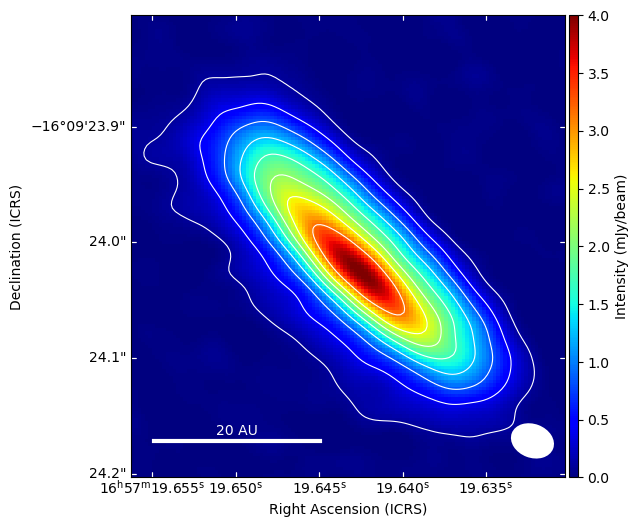

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=cropped_wcs)

im = ax.imshow(cropped_data*1e3, cmap='jet', origin='lower', vmin=0.00, vmax=4)
colorbar = fig.colorbar(im, ax=ax, pad=0.005, aspect=50)
colorbar.set_label('Intensity (mJy/beam)')

sigma_levels = [5, 20, 40, 60, 80, 100, 120, 150]
contour_levels = [level * rms_noise for level in sigma_levels]
contours = ax.contour(cropped_data, levels=contour_levels, colors='w', linewidths=0.8)

beam = Ellipse((115, 10), width=beam_minor_pixels, height=beam_major_pixels,
               angle=beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
ax.add_patch(beam)

plt.plot([30-10/au_per_pix, 30+10/au_per_pix],[10, 10], "w", lw=3)
plt.text(30, 15, '20 AU', color='w', ha='center', va='top')

ax.set_xlabel('Right Ascension (ICRS)')
ax.set_ylabel('Declination (ICRS)')
plt.tick_params(direction='in', color='w')

In [9]:
plt.savefig('CB68_conti.pdf', transparent=True)
plt.savefig('CB68_conti.png')
plt.close('all')